# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


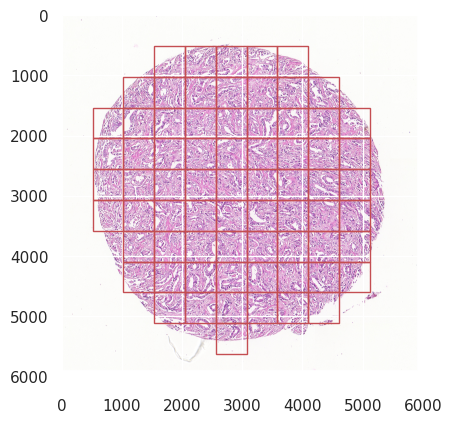

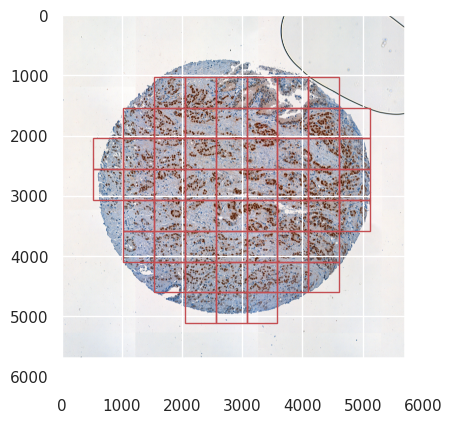

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

In [6]:
# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Define VAE
# 3. Instantiate the model
vae = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)
Utilities.convert_model_to_bf16(vae)

VanillaEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=64, out_features=64, bias=True)
  (fc_var): Linear(in_features=64, out_features=64, bias=True)
  (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_input): Linear(in_features=64, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, mome

In [9]:
vae.count_dtypes()

torch.bfloat16: 22 parameters
torch.float32: 4 parameters


In [10]:
test_patch_src = patches_src[10]
test_patch_dst = patches_dst[10]


test_patch_src_tensor = Utilities.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = Utilities.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [11]:
test_patch_src_tensor = test_patch_src_tensor.to(device, dtype=torch.bfloat16)
with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        en = vae(test_patch_src_tensor)
en.shape

torch.Size([1, 64, 128, 128])

In [12]:
# Define UNET
# Create model with matching in_channels
model = AdaINUNet(
    in_channels=64,  # Changed from 3 to 64 to match your input
    out_channels=3,
    time_emb_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # Creates a model with 4 resolution levels
    num_res_blocks=2,            # 2 residual blocks per resolution
    attention_resolutions=(4, 8),  # Add attention at 8×8 and 16×16 resolutions
    dropout=0.1,
    style_strength=1.0,
    device=device
).to(device)

# Convert model parameters to bfloat16
for param in model.parameters():
    param.data = Utilities.convert_to_bfloat16(param.data)

In [13]:
model.count_dtypes()

torch.bfloat16: 298 parameters


In [14]:
# Define StyleExtractor
extractor = StyleExtractor()
extractor = extractor.to(device='cuda', dtype=torch.bfloat16)

with torch.no_grad():
    with torch.amp.autocast(device_type='cuda',dtype=torch.bfloat16):
        encoded = extractor(test_patch_src_tensor)

encoded.view(1, 64, 128, 128).shape

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 128, 128])

In [15]:
# Define Decoder
decoder = VanillaDecoder(in_channels=64, latent_dim=64, output_channels=3).to('cuda', dtype=torch.bfloat16)  # [1, 64, 64, 64]

In [16]:
pipeline = nn.Sequential(
    vae,
    model,
    decoder
).to(device='cuda', dtype=torch.bfloat16)

In [17]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 61412480


In [18]:
import torch.optim as optim


In [19]:
# Hyperparameters for training
num_epochs = 10
batch_size = 1

# Careful initialization and stabilization
# Using a very small learning rate initially to stabilize
learning_rate = 1e-6  # Starting with a smaller learning rate
losses = []
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], 
                        lr=learning_rate, weight_decay=1e-6, eps=1e-8)

# Significantly reduce lambda values to prevent loss explosion
lambda_structure = 0.01
lambda_content = 0.001
lambda_style = 0.0001
lambda_color = 0.01

# Put on training mode
model.train()
vae.train()
decoder.train()
extractor.train()


# Switch to main training with bfloat16
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_losses = []
    
    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst)

        # Initially load as float32 for stability, then convert to bfloat16
        src_tensor = src_tensor.to(device, dtype=torch.float32)
        dst_tensor = dst_tensor.to(device, dtype=torch.float32)
        
        # Now convert to bfloat16 after initial loading
        src_tensor = src_tensor.to(dtype=torch.bfloat16)
        dst_tensor = dst_tensor.to(dtype=torch.bfloat16)

        # Zero gradients
        optimizer.zero_grad()
        
        try:
            # Start with fixed timesteps for stability
            timestep_value = min(100, epoch * 10)  # Gradually increase timesteps
            timesteps = torch.full((batch_size,), timestep_value, device=device, dtype=torch.long)

            # Forward pass with careful error handling
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                # Use try/except for each component
                try:
                    encoded = vae(src_tensor)
                    if torch.isnan(encoded).any():
                        print(f"Batch {i+1}: NaN in VAE encoding")
                        continue
                        
                    try:
                        style = extractor(dst_tensor)
                        if torch.isnan(style).any():
                            print(f"Batch {i+1}: NaN in style extraction")
                            continue
                            
                        style = style.view(batch_size, 64, 128, 128)
                        
                        try:
                            output = model(encoded, timesteps, style)
                            if torch.isnan(output).any():
                                print(f"Batch {i+1}: NaN in model output")
                                continue
                                
                            try:
                                reconstructed = decoder(output)
                                if torch.isnan(reconstructed).any():
                                    print(f"Batch {i+1}: NaN in decoder output")
                                    continue
                                    
                                # First calculate loss components individually for debugging
                                try:
                                    # Start with a simple MSE loss as a baseline
                                    mse_loss = torch.nn.functional.mse_loss(reconstructed, src_tensor)
                                    
                                    # Only add the other losses if MSE is stable
                                    if not torch.isnan(mse_loss):
                                        structure_l = lambda_structure * structure_preservation_loss(
                                            original_image=src_tensor, 
                                            generated_image=reconstructed,
                                            lambda_structure=1.0  # Using 1.0 here since we're scaling outside
                                        )
                                        
                                        ca_l = lambda_color * color_alignment_loss(
                                            original_image=src_tensor,
                                            generated_image=reconstructed,
                                            lambda_color=1.0  # Using 1.0 here since we're scaling outside
                                        )
                                        
                                        content_l = lambda_content * content_loss(
                                            original_image=src_tensor,
                                            generated_image=reconstructed,
                                            lambda_content=1.0  # Using 1.0 here since we're scaling outside
                                        )
                                        
                                        style_l = lambda_style * style_loss(
                                            original_image=src_tensor,
                                            generated_image=reconstructed,
                                            lambda_style=1.0  # Using 1.0 here since we're scaling outside
                                        )
                                        
                                        # Check each component before adding
                                        if torch.isnan(structure_l):
                                            print(f"Batch {i+1}: NaN in structure loss")
                                            structure_l = torch.tensor(0.0, device=device, dtype=torch.bfloat16)
                                            
                                        if torch.isnan(ca_l):
                                            print(f"Batch {i+1}: NaN in color alignment loss")
                                            ca_l = torch.tensor(0.0, device=device, dtype=torch.bfloat16)
                                            
                                        if torch.isnan(content_l):
                                            print(f"Batch {i+1}: NaN in content loss")
                                            content_l = torch.tensor(0.0, device=device, dtype=torch.bfloat16)
                                            
                                        if torch.isnan(style_l):
                                            print(f"Batch {i+1}: NaN in style loss")
                                            style_l = torch.tensor(0.0, device=device, dtype=torch.bfloat16)
                                        
                                        # Weighted sum with MSE as base
                                        loss = mse_loss + structure_l + ca_l + content_l + style_l
                                    else:
                                        print(f"Batch {i+1}: NaN in MSE loss")
                                        continue
                                                                            
                                except Exception as e:
                                    print(f"Batch {i+1}: Error in loss calculation: {e}")
                                    continue
                                    
                            except Exception as e:
                                print(f"Batch {i+1}: Error in decoder: {e}")
                                continue
                                
                        except Exception as e:
                            print(f"Batch {i+1}: Error in model: {e}")
                            continue
                            
                    except Exception as e:
                        print(f"Batch {i+1}: Error in extractor: {e}")
                        continue
                        
                except Exception as e:
                    print(f"Batch {i+1}: Error in VAE: {e}")
                    continue
                    
            # Check if loss has NaN before backward
            if torch.isnan(loss):
                print(f"Batch {i+1}: Final loss is NaN, skipping")
                continue

            # Backward pass with a small loss scaling for stability
            (loss * 0.1).backward()
            
            # Very aggressive gradient clipping
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=0.1)
            torch.nn.utils.clip_grad_norm_([p for p in vae.parameters() if p.requires_grad], max_norm=0.1)
            torch.nn.utils.clip_grad_norm_([p for p in decoder.parameters() if p.requires_grad], max_norm=0.1)
            torch.nn.utils.clip_grad_norm_([p for p in extractor.parameters() if p.requires_grad], max_norm=0.1)
            
            # Check for NaN gradients
            has_nan_grad = False
            for module, name in [(model, "model"), (vae, "vae"), (decoder, "decoder"), (extractor, "extractor")]:
                for param_name, param in module.named_parameters():
                    if param.grad is not None and torch.isnan(param.grad).any():
                        print(f"Batch {i+1}: NaN gradient in {name}.{param_name}")
                        has_nan_grad = True
                        break
                if has_nan_grad:
                    break
            
            if has_nan_grad:
                optimizer.zero_grad()
                continue
                
            # Step optimizer
            optimizer.step()
            
            # Track losses
            epoch_losses.append(loss.item())
            print(f"Batch {i+1} - Loss: {loss.item():.8f}")
            if 'structure_l' in locals():
                print(f"  - MSE: {mse_loss.item():.8f}, Structure: {structure_l.item():.8f}")
                print(f"  - Color: {ca_l.item():.8f}, Content: {content_l.item():.8f}, Style: {style_l.item():.8f}")
                
        except Exception as e:
            print(f"Batch {i+1}: Unexpected error: {e}")
            continue
    
    # Print epoch summary
    if epoch_losses:
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.8f}")
        
        # Learning rate scheduling - increase gradually if stable
        if epoch > 0 and len(losses) > 1 and losses[-1] < losses[-2]:
            for param_group in optimizer.param_groups:
                param_group['lr'] = min(learning_rate * 2, 1e-4)
                print(f"Increasing learning rate to {param_group['lr']}")
    else:
        print(f"Epoch {epoch+1}/{num_epochs} - All batches had NaN losses")
        
    # Save checkpoint
    if epoch_losses:  # Only save if we had valid losses
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
        }, f'checkpoint_epoch_{epoch+1}.pt')

Epoch 1/10


/tmp/ipykernel_3308/3278872481.py:83: UserWarning: Using a target size (torch.Size([1, 3, 512, 512])) that is different to the input size (torch.Size([1, 3, 120, 120])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(reconstructed, src_tensor)


Batch 1: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 2: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 3: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 4: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 5: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 6: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 7: Error in loss calculation: The size of tensor a (120) must match the size of tensor b (512) at non-singleton dimension 3
Batch 8: Error in loss calculation: The size of tensor a (120) must match the size of tens

KeyboardInterrupt: 

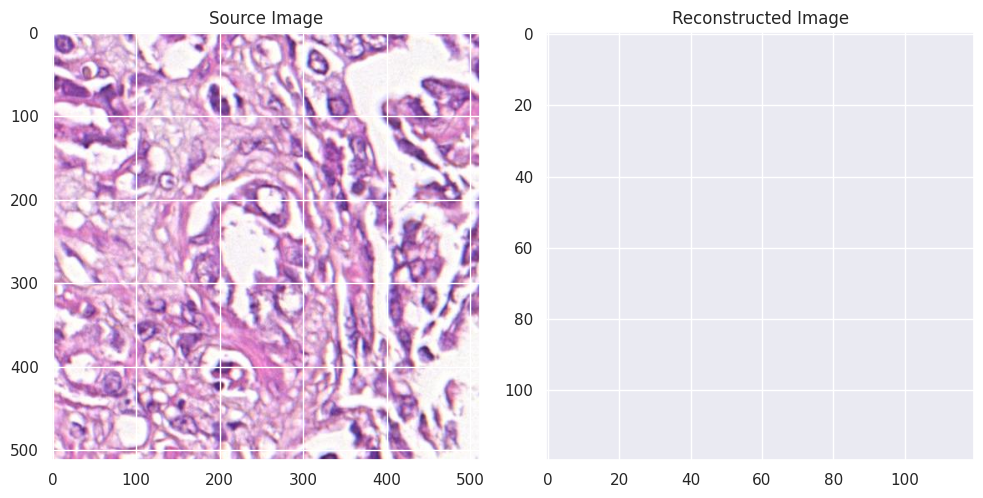

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(src)
ax[0].set_title("Source Image")

ax[1].imshow((((reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()))*255)[0].cpu().float().permute(1,2,0).detach().numpy())
ax[1].set_title("Reconstructed Image")

plt.tight_layout()
plt.show()


In [ ]:
if reconstructed.shape != src_tensor.shape:
        # print("Original and generated images have different shapes. Resizing generated image to match original image.")
        reconstructed = F.interpolate(reconstructed, size=src_tensor.shape[2:], mode="bilinear", align_corners=False)

In [ ]:
mse_loss = F.mse_loss(reconstructed, src_tensor)

In [ ]:
sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                    dtype=torch.bfloat16, device=src_tensor.device).view(1, 1, 3, 3).repeat(3, 1, 1, 1)
sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                    dtype=torch.bfloat16, device=src_tensor.device).view(1, 1, 3, 3).repeat(3, 1, 1, 1)

In [ ]:
 # Apply edge detection
orig_edges_x = F.conv2d(src_tensor, sobel_x, padding=1, groups=3)
orig_edges_y = F.conv2d(src_tensor, sobel_y, padding=1, groups=3)
orig_edges = torch.sqrt(orig_edges_x**2 + orig_edges_y**2)

gen_edges_x = F.conv2d(reconstructed, sobel_x, padding=1, groups=3)
gen_edges_y = F.conv2d(reconstructed, sobel_y, padding=1, groups=3)
gen_edges = torch.sqrt(gen_edges_x**2 + gen_edges_y**2)

# Edge preservation loss
edge_loss = F.mse_loss(gen_edges, orig_edges)

# Total loss
total_loss = mse_loss + edge_loss

In [ ]:
total_loss * 1e-3

tensor(nan, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>)

In [ ]:
(((reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()))*255)

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<MulBackward0>)

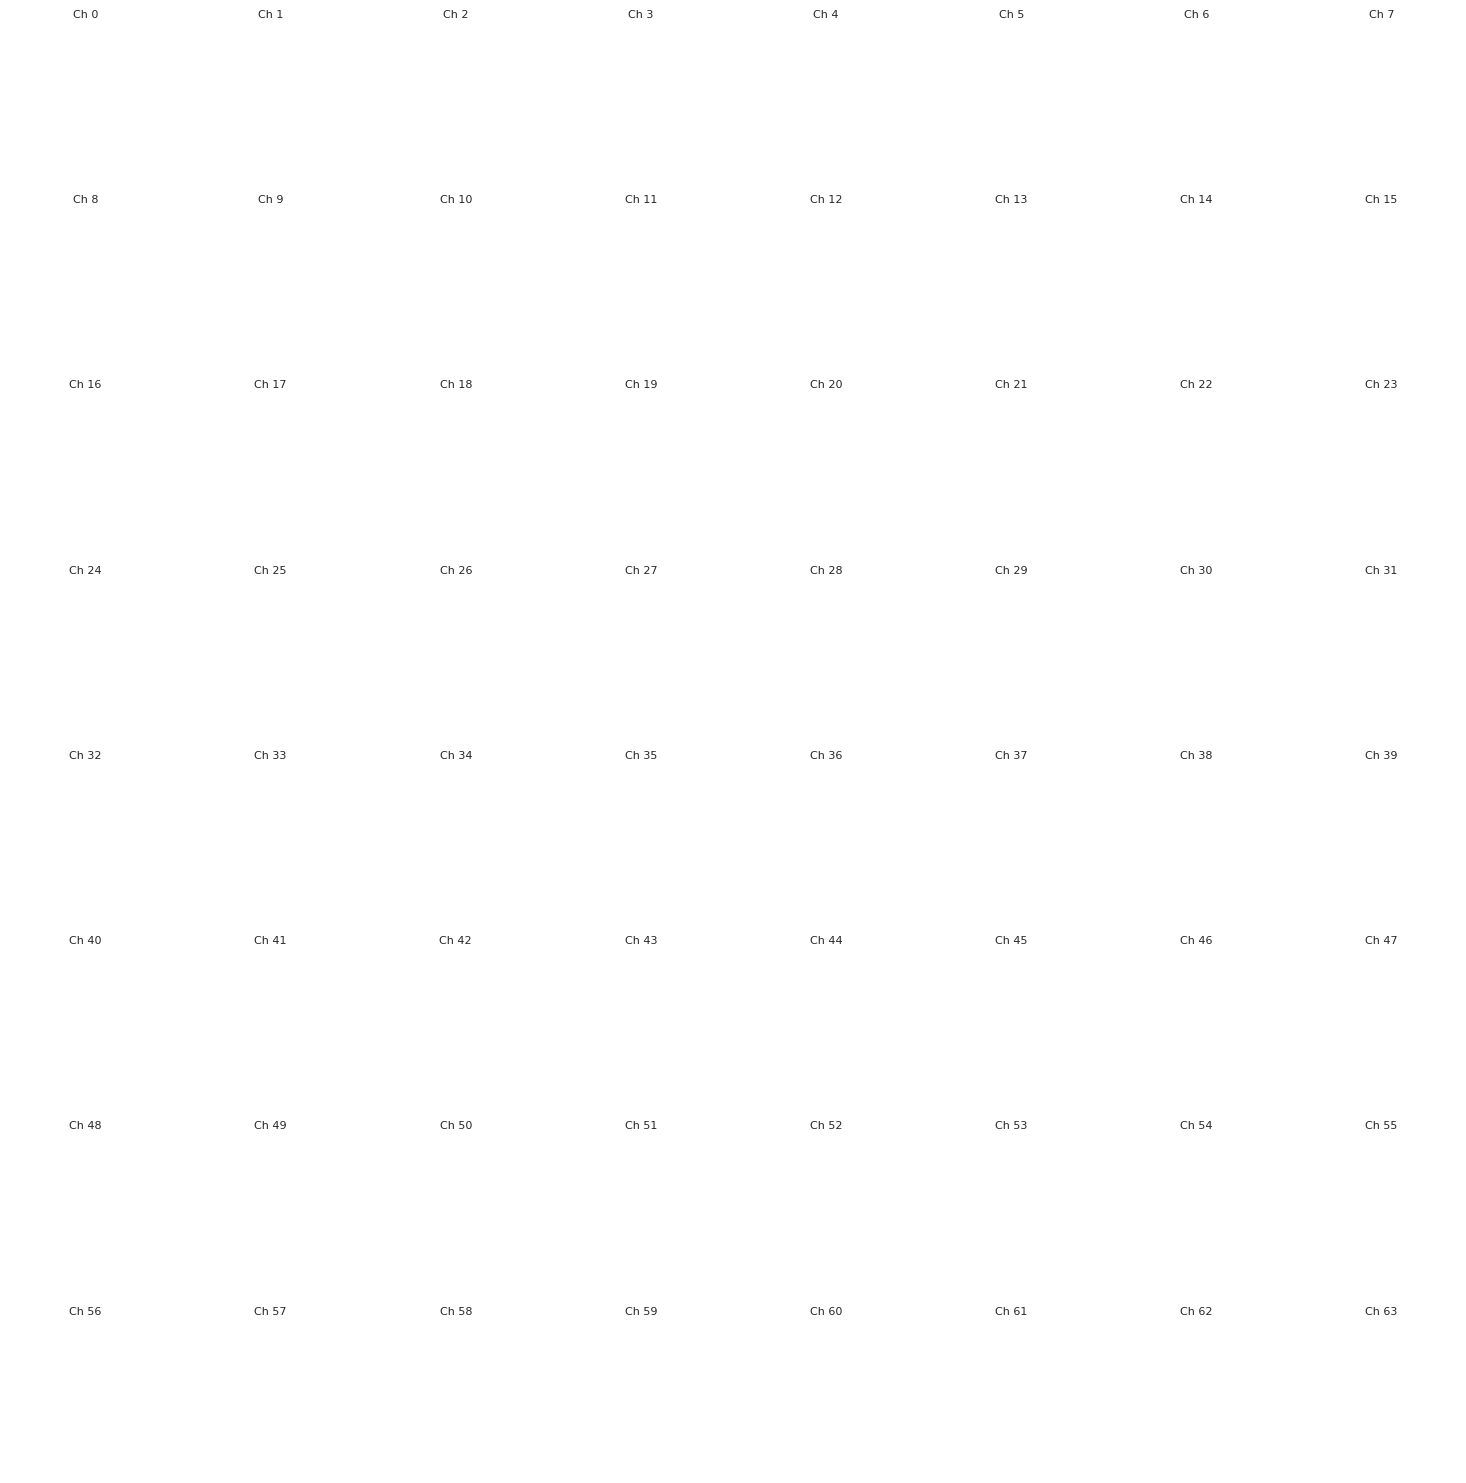

In [ ]:
x = output  # Assuming x has shape [1, 64, H, W]

fig, axes = plt.subplots(8, 8, figsize=(15, 15))  # 8x8 grid
for i in range(64):
    ax = axes[i // 8, i % 8]
    ax.imshow(x[0, i].float().detach().cpu().numpy(), cmap='viridis')
    ax.set_title(f'Ch {i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()
